# Решение

## 1. Скачать файл по ссылке

In [1]:
!wget 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv' 'titanic.csv'

--2022-02-12 09:54:12--  https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57018 (56K) [text/plain]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  55.68K  --.-KB/s    in 0.008s  

2022-02-12 09:54:13 (6.57 MB/s) - ‘titanic.csv’ saved [57018/57018]

--2022-02-12 09:54:13--  http://titanic.csv/
Resolving titanic.csv (titanic.csv)... failed: Name or service not known.
wget: unable to resolve host address ‘titanic.csv’
FINISHED --2022-02-12 09:54:13--
Total wall clock time: 0.3s
Downloaded: 1 files, 56K in 0.008s (6.57 MB/s)


## 2. Изучение данных

### Информация

In [2]:
import pandas as pd

df = pd.read_csv('/content/titanic.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


#### определение переменных для дальнейшей работы

In [ ]:
survived = 'survived'
pclass = 'pclass'
sex = 'sex'
age = 'age'
sibsp = 'sibsp'
parch = 'parch'
fare = 'fare'
embarked = 'embarked'
class_ = 'class'
who = 'who'
adult_male = 'adult_male'
deck = 'deck'
embark_town = 'embark_town'
alive = 'alive'
alone = 'alone'

### Пропуски:
* возраст (age, 177 пропусков)
* порт посадки (embarked, 2 пропуска)
* палуба (deck, 688 пропусков)
* город посадки (embark_town, 2 пропуска)

### Заполениние пропусков
#### Возраст 
Принято решение написать небольшую модель, обучить ее на заполненных данных и предугадать примерный возраст в пропущенных ячейках. 

#### Порт посадки 
Все пропуски = `U` (unknown).

#### Город посадки
Все пропуски = `Unknown`.

#### Палуба
Все пропуски = `U`.



#### Пропуски посадки

In [ ]:
def fill_na_embark(data_frame: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame: 
    data_frame['embarked'] = data_frame['embarked'].fillna('U')
    data_frame['embark_town'] = data_frame['embark_town'].fillna('Unknown')

    return data_frame

In [ ]:
def for_print_embark(data_frame: pd.core.frame.DataFrame, column_offset: int = 4) -> pd.core.frame.DataFrame:
    """
    Функция для отображения информации 
    об уникальных значениях в столбцах 'embarked' и 'embark_town'
    """
    for_print = [('Порты:', 'Города:')]
    max_len_port = len(for_print[0][0])
    output_str = ''

    unique_ports, unique_towns = df['embarked'].unique(), df['embark_town'].unique()
    
    for index in range(max(len(unique_ports), len(unique_towns))):
        temp_port = unique_ports[index] if index < len(unique_ports) else ''
        temp_town = unique_towns[index] if index < len(unique_towns) else ''

        max_len_port = max(max_len_port, len(temp_port))

        for_print.append((temp_port, temp_town))

    for port, town in for_print: 
        output_str += f'{port}{" " * (max_len_port + column_offset - len(port))}{town}\n'

    return output_str

In [ ]:
df = fill_na_embark(df)
print(for_print_embark(df))

Порты:    Города:
S         Southampton
C         Cherbourg
Q         Queenstown
U         Unknown



#### Пропуски возраста

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, concatenate

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import mse, binary_crossentropy, sparse_categorical_crossentropy, mae, cosine_similarity, log_cosh
from tensorflow.keras.metrics import mae as mae_
from tensorflow.keras.activations import softsign, relu, softmax

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def prepare_data(data_frame): 
    data_frame_copy = data_frame.copy()
    data_frame_copy['pclass'] = data_frame_copy['pclass'].apply(lambda pcls: P_CLASSES[pcls])
    data_frame_copy['sex'] = data_frame_copy['sex'].apply(lambda sex: int(sex == 'female'))
    data_frame_copy['fare'] *= FARE_NORMALIZER
    data_frame_copy['sibsp'] *= SIBSP_NORMALIZER
    data_frame_copy['parch'] *= PARCH_NORMALIZER
    data_frame_copy['class'] = data_frame_copy['class'].apply(lambda cls: CLASSES[cls])
    data_frame_copy['alive'] = data_frame_copy['alive'].apply(lambda alive: int(alive == 'yes'))
    data_frame_copy['alone'] = data_frame_copy['alone'].apply(int)

    data_frame_copy['age'] *= AGE_NORMALIZER

    return data_frame_copy

In [ ]:
X_COLUMNS = ['pclass', 'sex', 'sibsp', 'parch', 'fare', 'class', 'alive', 'alone']
Y_COLUMNS = ['age']
AGE_NORMALIZER = 0.01
FARE_NORMALIZER = 0.001
SIBSP_NORMALIZER = 0.1
PARCH_NORMALIZER = 0.1
CLASSES = {'First': 0.1, 'Second': 0.5, 'Third': 0.9}
P_CLASSES = {1: 0.1, 2: 0.5, 3: 0.9}


data = df[df.loc[:, 'age'].notna()]
prepared_data = prepare_data(data)
x_data, y_data = prepared_data[X_COLUMNS].to_numpy(), prepared_data[Y_COLUMNS].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.9)

In [ ]:
def data_augmentation(x, y, count=1, x_transformations=tuple()):
    new_x, new_y = [0] * count, [0] * count
    for new_index in range(count):
        old_index = np.random.choice(len(x), 1)
        new_x_elem = np.array(x[old_index], copy=True)[0]
        
        for transform in x_transformations:
            if transform['t_variant'] == 1:
                minimum = max(transform['min'], new_x_elem[transform['index']] - transform['max_minus'])
                maximum = min(transform['max'], new_x_elem[transform['index']] + transform['max_plus'])
                new_value = np.random.uniform(minimum, maximum)
                new_x_elem[transform['index']] = round(new_value, transform['round'])

            elif transform['t_variant'] == 2:
                if new_x_elem[transform['index']] not in transform['choice']:
                    continue
                index_before_transformation = transform['choice'].index(new_x_elem[transform['index']])
                minimum_index = max(0, index_before_transformation - transform['max_minus'])
                maximum_index = min(len(transform['choice']),
                                    index_before_transformation + transform['max_plus'] + 1)

                choice_from = transform['choice'][minimum_index:maximum_index]
                new_value = np.random.choice(choice_from)
                new_x_elem[transform['index']] = new_value
                
        new_x[new_index] = new_x_elem
        new_y[new_index] = y[old_index]
    return np.array(new_x), np.array(new_y)[:, 0]


In [ ]:
new_x_train, new_y_train = data_augmentation(
    x_train, y_train, count=300,
    x_transformations=[
        {  # sibsp
            'index': 2,
            't_variant': 2,
            'choice': [0.1 * i for i in range(8)],
            'max_plus': 1,
            'max_minus': 1,
        },
        {  # parch
            'index': 3,
            't_variant': 2,
            'choice': [0.1 * i for i in range(8)],
            'max_plus': 0,
            'max_minus': 1,
        },
        {  # fare
            'index': 4,
            't_variant': 1,
            'min': 0,
            'max': 1,
            'max_plus': 0.010,
            'max_minus': 0.010,
            'round': 7
        }
    ])


In [ ]:
total_x_train, total_y_train = (
    np.concatenate((x_train, new_x_train)), 
    np.concatenate((y_train, new_y_train))
)

In [ ]:
total_x_train.shape

(942, 8)

In [ ]:
def create_model():
    input_layer = Input(len(X_COLUMNS))
    layers_values = ((16, relu), 
                     (256, relu), 
                     (512, relu),
                     (768, relu),
                     (768, relu),
                     (768, relu),
                     (1024, relu),
                     (4096, relu),
                     (4096, relu),
                     (1024, relu),
                     (512, relu),
                     (256, relu),
                     (128, relu),
                     (128, relu), 
                     (56, relu), 
                     (len(Y_COLUMNS), 'sigmoid'))
    last_layer = Dense(layers_values[0][0], layers_values[0][1])(input_layer)
    for units, activation in layers_values[1:]:
        last_layer = Dense(units, activation)(last_layer)

    return Model(input_layer, last_layer)


In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [ ]:
model = create_model()
model.compile(optimizer=Adam(), loss=mse, metrics=[mae_])

In [ ]:
history = model.fit(total_x_train, total_y_train, batch_size=4, ep ochs=600, verbose=1).history

Epoch 1/600
236/236 [==============================] - 7s 22ms/step - loss: 0.0225 - mean_absolute_error: 0.1193
Epoch 2/600
236/236 [==============================] - 5s 22ms/step - loss: 0.0193 - mean_absolute_error: 0.1116
Epoch 3/600
236/236 [==============================] - 6s 24ms/step - loss: 0.0184 - mean_absolute_error: 0.1087
Epoch 4/600
236/236 [==============================] - 6s 26ms/step - loss: 0.0189 - mean_absolute_error: 0.1098
Epoch 5/600
236/236 [==============================] - 4s 17ms/step - loss: 0.0175 - mean_absolute_error: 0.1061
Epoch 6/600
236/236 [==============================] - 4s 17ms/step - loss: 0.0173 - mean_absolute_error: 0.1047
Epoch 7/600
236/236 [==============================] - 4s 17ms/step - loss: 0.0160 - mean_absolute_error: 0.1020
Epoch 8/600
236/236 [==============================] - 4s 17ms/step - loss: 0.0163 - mean_absolute_error: 0.1013
Epoch 9/600
236/236 [==============================] - 4s 17ms/step - loss: 0.0164 - mean_absolu

Text(0, 0.5, 'Точность, %')

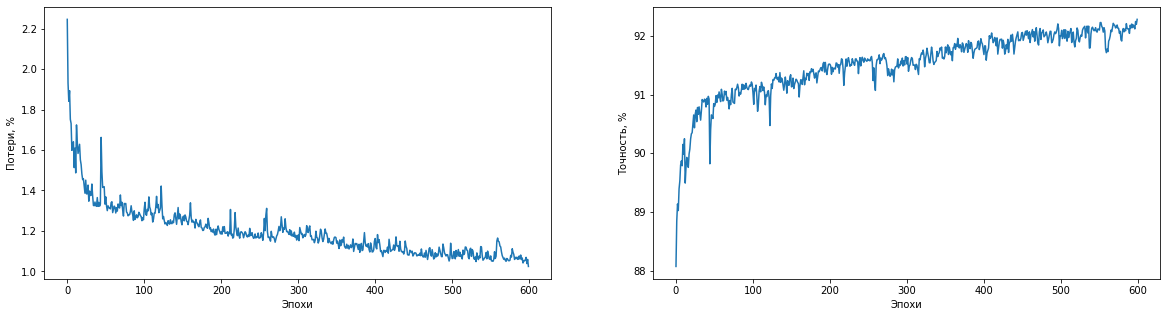

In [ ]:
fig, (losses_ax, metrics_ax) = plt.subplots(1, 2)
fig.set_size_inches(20, 5)

losses_ax.plot([x * 100 for x in history.get('loss')])
losses_ax.set_xlabel('Эпохи')
losses_ax.set_ylabel('Потери, %')

metrics_ax.plot([(1 - x) * 100 for x in history.get('mean_absolute_error')])
metrics_ax.set_xlabel('Эпохи')
metrics_ax.set_ylabel('Точность, %')

In [ ]:
model.evaluate(x_test, y_test)[1] / AGE_NORMALIZER

3/3 [==============================] - 0s 10ms/step - loss: 0.0111 - mean_absolute_error: 0.0775


7.7493540942668915

In [ ]:
x_test.shape

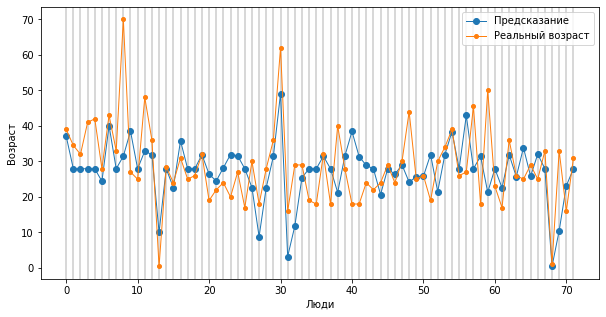

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)

predicts = model.predict(x_test)

[ax.axvline(x, color='#ccc') for x in range(len(predicts))]
ax.plot(predicts / AGE_NORMALIZER, label='Предсказание', linewidth=1, markersize=6, marker='o')
ax.plot(y_test / AGE_NORMALIZER, label='Реальный возраст', linewidth=1, markersize=4, marker='o')

ax.plot
ax.set_xlabel('Люди')
ax.set_ylabel('Возраст')
ax.legend()

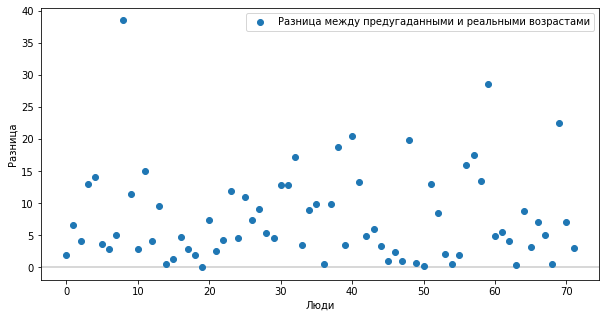

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)

predicts = model.predict(x_test)

ax.axhline(0, color='#ccc')
ax.plot(np.absolute(predicts / AGE_NORMALIZER - y_test / AGE_NORMALIZER), label='Разница между предугаданными и реальными возрастами', linewidth=0, markersize=6, marker='o')

ax.plot
ax.set_xlabel('Люди')
ax.set_ylabel('Разница')
ax.legend()

##### Сохранение модели

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir /content/drive/MyDrive/yandex-lyceum-selection-round
!mkdir /content/drive/MyDrive/yandex-lyceum-selection-round/models

In [ ]:
model.save('/content/drive/MyDrive/yandex-lyceum-selection-round/models/age-model')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/yandex-lyceum-selection-round/models/age-model/assets


In [ ]:
model.save('/content/drive/MyDrive/yandex-lyceum-selection-round/models/age-model.h5')